In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
from collections import defaultdict

from sklearn.preprocessing import minmax_scale

from matplotlib import rcParams
import matplotlib.pyplot as plt
import seaborn as sb

import sys
sys.path.insert(0, '/lustre/groups/ml01/code/karin.hrovatin/diabetes_analysis/')
from importlib import reload  
import helper as h
reload(h)
import helper as h

In [2]:
path_rna='/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/'
path_data=path_rna+'combined/'
path_genes='/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/gene_lists/'
path_de='/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/combined/de/'
path_de1=path_de+'de_diseased_T1_NODelim_meld/'
path_de2=path_de+'de_diseased_T2_VSGSTZ_meld_covarStudy/'

In [3]:
# Saving figures
path_fig='/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/figures/paper/'

In [4]:
# Orthologues
orthologues=pd.read_table(path_genes+'orthologues_ORGmus_musculus_ORG2homo_sapiens_V103.tsv'
                         ).rename(
    {'Gene name':'gene_symbol_mm','Human gene name':'gene_symbol_hs',
     'Gene stable ID':'EID_mm','Human gene stable ID':'EID_hs'},axis=1)

## DE cluster scores
In each study subset to healthy and diseased sample beta cells, score for DE gene groups, and plot scores in healthy and diseased sample groups

In [5]:
# Get T1 and t2 clusters as dict cl:eids
cl_t1=pd.read_table(path_de1+'deDataClusters.tsv',index_col=0
                   ).groupby('hc').apply(lambda x:list(x.index)).to_dict()
cl_t2=pd.read_table(path_de2+'deDataClusters.tsv',index_col=0
                   ).groupby('hc').apply(lambda x:list(x.index)).to_dict()

T2D

In [15]:
dt='T2D'
res=[]
for study_name,file,gene_type in [
    # Studies to use
    # study name in format species_studyname, folder suffix, gene type to use - if this col
    # in var then uses this col else assumes that index contains it
    ('hs GSE83139','GSE83139/GEO/','gene_symbol'),
    ('hs GSE154126','GSE154126/GEO/','gene_symbol'),
    ('hs GSE101207','GSE101207/GEO/','gene_symbol'),
    ('hs GSE124742_GSE164875_patch','GSE124742_GSE164875/GEO/patch/','gene_symbol'),
    ('hs GSE124742_FACS','GSE124742_GSE164875/GEO/FACS/','gene_symbol'),
    ('hs GSE81608','GSE81608/GEO/','gene_symbol'),
    ('hs GSE86469','GSE86469/GEO/','EID'),
    ('mm GSE137909','GSE137909/GEO/','EID'),
]:
    species=study_name.split(' ')[0]
    file=file + 'adata_filtered.h5ad' if species=='hs' else file + 'adata.h5ad'
    adata= sc.read(path_rna+file)
    # USe only beta cells
    adata=adata[(adata.obs.cell_type=='beta').values ].copy()
    # Sample subset
    adata=adata[(adata.obs.disease.isin(['healthy',dt])).values ]
    print(study_name)
    n_cells=adata.obs['disease'].value_counts().to_dict()
    display(n_cells)
    # If index does not have only unique values reset index
    if adata.shape[1]>adata.var_names.nunique():
        if gene_type not in adata.var.columns:
            adata.var[gene_type]=adata.var_names
        adata.var_names=adata.var.reset_index().index
    # Scores
    for cl,genes in cl_t2.items():
        score_name=dt+'_'+str(cl)
        # Map to human genes
        if species=='hs':
            genes=list(orthologues.query('EID_mm in @genes')[gene_type+'_hs'])
        # Remove unused genes
        # Also map to gene names used in index
        if gene_type in adata.var.columns:
            genes=adata.var.index[adata.var[gene_type].isin(genes)]
        else:
            genes=[g for g in genes if g in adata.var_names]
        sc.tl.score_genes(adata, gene_list=genes, score_name=score_name, use_raw=False)
        # Build df for plotting
        res_sub=adata.obs[[score_name,'disease']].copy()
        res_sub[score_name]=minmax_scale(res_sub[score_name])
        res_sub.rename({score_name:'score'},axis=1,inplace=True)
        res_sub['gene group']=score_name
        res_sub['study']=study_name+\
            ' N: H '+str(n_cells['healthy'])+' D '+str(n_cells[dt])
        res_sub['direction']=cl.split('_')[0]
        res.append(res_sub)
res=pd.concat(res,axis=0)

hs GSE83139


{'healthy': 67, 'T2D': 38}

Trying to set attribute `.obs` of view, copying.


hs GSE154126


{'healthy': 136, 'T2D': 46}

Trying to set attribute `.obs` of view, copying.


hs GSE101207


{'healthy': 8092, 'T2D': 1866}

Trying to set attribute `.obs` of view, copying.


hs GSE124742_GSE164875_patch


{'healthy': 377, 'T2D': 107}

Trying to set attribute `.obs` of view, copying.


hs GSE124742_FACS


{'healthy': 514, 'T2D': 160}

Trying to set attribute `.obs` of view, copying.


hs GSE81608


{'T2D': 296, 'healthy': 207}

Trying to set attribute `.obs` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


hs GSE86469


{'healthy': 168, 'T2D': 96}

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


mm GSE137909


{'healthy': 725, 'T2D': 280}

Trying to set attribute `.obs` of view, copying.


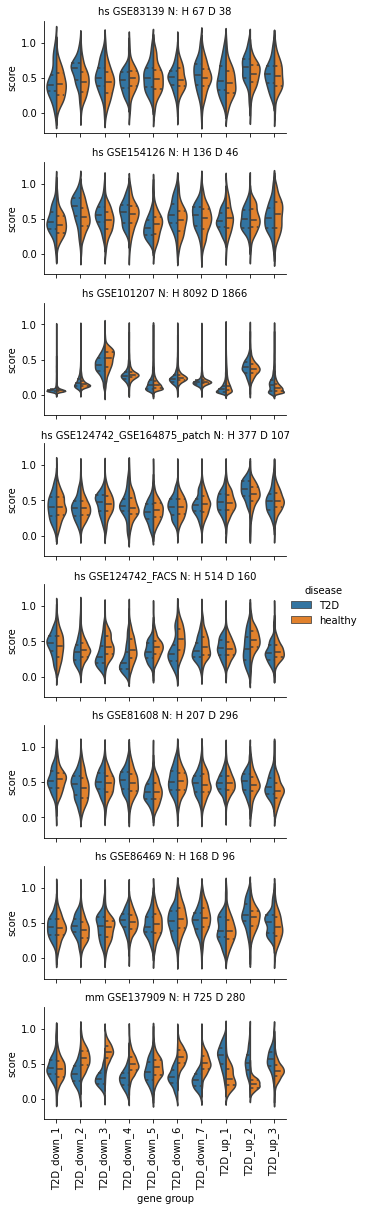

In [16]:
# Plot DE group scores across datasets
g=sb.catplot(x="gene group", y="score", hue="disease", row="study",#col='direction',
           data=res, kind="violin", split=True,
           height=2, aspect=2, inner="quartile")
g.set_xticklabels(rotation=90)
g.set_titles(template='{row_name}')
g.set(facecolor = (0,0,0,0))
plt.savefig(path_fig+'violin_beta_T2DVSGSTZScoresComparison.png',dpi=300,bbox_inches='tight')

C: it seems that overall DE is not preserved in human. But it is preserved in mouse. T2D_down_1/5 (not conserved in mouse) are not expressed in all healthy states in atlas as well so maybe that is why there is no difference - the healthy up population may not be present in this mm study.

T1D

In [17]:
dt='T1D'
res=[]
for study_name,file,gene_type in [
    # Studies to use
    # study name in format species_studyname, folder suffix, gene type to use - if this col
    # in var then uses this col else assumes that index contains it
    ('hs GSE83139','GSE83139/GEO/','gene_symbol'),
    ('hs GSE124742_GSE164875_patch','GSE124742_GSE164875/GEO/patch/','gene_symbol'),
    ('hs GSE148073','GSE148073/GEO/','EID'),
]:
    species=study_name.split(' ')[0]
    file=file + 'adata_filtered.h5ad' if species=='hs' else file + 'adata.h5ad'
    adata= sc.read(path_rna+file)
    # USe only beta cells
    adata=adata[(adata.obs.cell_type=='beta').values ].copy()
    # Subset samples
    adata=adata[(adata.obs.disease.isin(['healthy',dt])).values ]
    print(study_name)
    n_cells=adata.obs['disease'].value_counts().to_dict()
    display(n_cells)
    # Scores
    for cl,genes in cl_t1.items():
        score_name=dt+'_'+str(cl)
        # Map to human genes
        if species=='hs':
            genes=list(orthologues.query('EID_mm in @genes')[gene_type+'_hs'])
        # Map to gene names used in index
        if gene_type in adata.var.columns:
            genes=adata.var.index[adata.var[gene_type].isin(genes)]
        # Remove unused genes
        else:
            genes=[g for g in genes if g in adata.var_names]
        sc.tl.score_genes(adata, gene_list=genes, score_name=score_name, use_raw=False)
        # Build df for plotting
        res_sub=adata.obs[[score_name,'disease']].copy()
        res_sub[score_name]=minmax_scale(res_sub[score_name])
        res_sub.rename({score_name:'score'},axis=1,inplace=True)
        res_sub['gene group']=score_name
        res_sub['study']=study_name+\
            ' N: H '+str(n_cells['healthy'])+' D '+str(n_cells[dt])
        res_sub['direction']=cl.split('_')[0]
        res.append(res_sub)
res=pd.concat(res,axis=0)

hs GSE83139


{'healthy': 67, 'T1D': 6}

Trying to set attribute `.obs` of view, copying.


hs GSE124742_GSE164875_patch


{'healthy': 377, 'T1D': 12}

Trying to set attribute `.obs` of view, copying.


hs GSE148073


{'healthy': 3158, 'T1D': 1071}

Trying to set attribute `.obs` of view, copying.


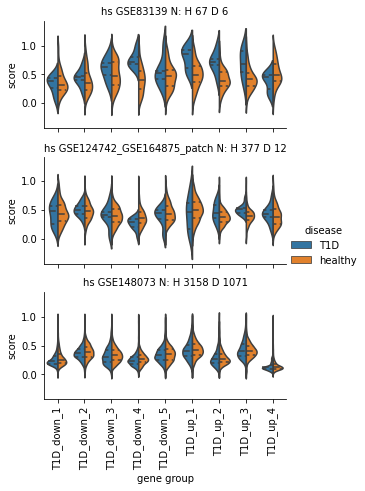

In [18]:
# Plot gene group scores across datasets
g=sb.catplot(x="gene group", y="score", hue="disease", row="study",#col='direction',
           data=res, kind="violin", split=True,
           height=2, aspect=2, inner="quartile")
g.set_xticklabels(rotation=90)
g.set_titles(template='{row_name}')
g.set(facecolor = (0,0,0,0))
plt.savefig(path_fig+'violin_beta_T1DNODelimScoresComparison.png',dpi=300,bbox_inches='tight')

C: Using PC1 computed on gene group genes instead of score_genes also did not help in translation of T1D to human.